In [1]:
############################################# STEPS1: Importing packages ######################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import os 
import sys
import random
from tqdm import tqdm
from keras.models import Model, load_model
from keras.layers import Input, Dense, MaxPooling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers
import tensorflow as tf

np.random.seed = 1337

# Set operating parameters
TRAIN_IMG_PATH = 'training_images/training_images'
VAL_IMG_PATH = 'validation_images/validation_images'
TEST_IMG_PATH = 'testing_images/testing_images'
TRAIN_MASK_PATH = 'training_masks/training_masks'
VAL_MASK_PATH= 'validation_masks/validation_masks'

IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3

# Get list of training and testing filenames
train_ids = next(os.walk(TRAIN_IMG_PATH))[2]
test_ids = next(os.walk(TEST_IMG_PATH))[2]
train_masks = next(os.walk(TRAIN_MASK_PATH))[2]
val_ids = next(os.walk(VAL_IMG_PATH))[2]
val_masks= next(os.walk(VAL_MASK_PATH))[2]

print('Done..!!')

C:\Users\chira\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done..!!


In [2]:
############################################# STEPS2: RESIZING IMAGES ######################################################
# Get and resize training images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing training images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

# Get and resize training mask images
Y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing training masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_masks), total=len(train_masks)):
    path = TRAIN_MASK_PATH + '/' + id_
    mask = imread(path)[:,:]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask
###########################################################################################
# Get and resize validation images
X_Val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing validation images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    path = VAL_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_Val[n] = img

# Get and resize training mask images
Y_Val = np.zeros((len(val_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing training masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_masks), total=len(val_masks)):
    path = VAL_MASK_PATH + '/' + id_
    mask = imread(path)[:,:]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_Val[n] = mask

###########################################################################################
    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


print('Done!')

Getting and resizing training images ... 


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:42<00:00, 35.63it/s]


Getting and resizing training masks ... 


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:30<00:00, 49.69it/s]


Getting and resizing validation images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.75it/s]


Getting and resizing training masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 69.14it/s]


Getting and resizing test images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 927/927 [00:20<00:00, 44.60it/s]


Done!


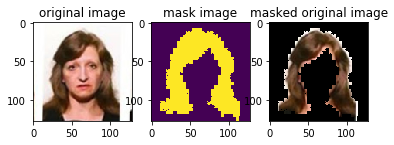

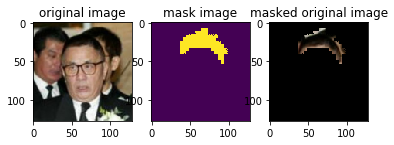

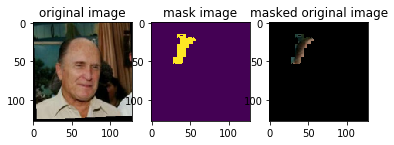

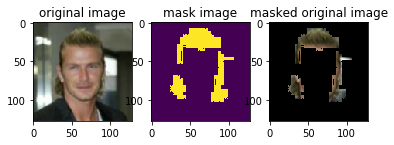

In [7]:
############################################## STEP3: PLOTTING SAMPLE IMAGES #################################################
# Checking if training and mask data looks right
for ix in np.arange(4):
    #Removing single-dimensional entries into 2D for mask to be plot
    mask = np.squeeze(Y_train[ix])
    # Create a masked image copy
    masked = np.copy(X_train[ix]) * Y_train[ix]
    # Display original, mask, and masked images side-by-side
    f, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.set_title('original image')
    ax0.imshow(X_train[ix])
    ax1.set_title('mask image')
    ax1.imshow(mask)
    ax2.set_title('masked original image')
    ax2.imshow(masked)
    plt.show()

In [5]:
############################################# STEPS4: FUNCTIONS ######################################################
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization
#function to calculate DICE coefficient
# formula: 2∗|X∩Y|/|X|+|Y|
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


# Define a U-Net neural network model
def unet(height, width, num_channels):
    inputs = Input((height, width, num_channels))
    inputs_ = Lambda(lambda x: x / 255) (inputs)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2_1') (inputs_)
    conv2=BatchNormalization()(conv2)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2_2') (conv2)
    conv2=BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2') (conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3_1') (pool2)
    conv3=BatchNormalization()(conv3)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3_2') (conv3)
    conv3=BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3') (conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4_1') (pool3)
    conv4=BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4_2') (conv4)
    conv4=BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4') (conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_1') (pool4)
    conv5=BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_2') (conv5)
    conv5=BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), name='pool5') (conv5)
    
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6_1') (pool5)
    conv6=BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6_2') (conv6)
    conv6=BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2), name='pool6') (conv6)
    
    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv6)
    up7 = concatenate([up7, conv5], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv7_1') (up7)
    conv7=BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv7_2') (conv7)
    conv7=BatchNormalization()(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv7)
    up8 = concatenate([up8, conv4], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv8_1') (up8)
    conv8=BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv8_2') (conv8)
    conv8=BatchNormalization()(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv8)
    up9 = concatenate([up9, conv3], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv9_1') (up9)
    conv9=BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv9_2') (conv9)
    conv9=BatchNormalization()(conv9)

    up10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv9)
    up10 = concatenate([up10, conv2], axis=3)
    conv10 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv10_1') (up10)
    conv10=BatchNormalization()(conv10)
    conv10 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv10_2') (conv10)
    conv10=BatchNormalization()(conv10)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv10)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

######################################### STEP5: BUILDING, FITTING MODEL ######################################################
print('========================================================================================')
print('Creating and compiling model...')
# building model
model = unet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model.summary()
#using Adam as optimizing algorithm
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-03,decay =0.0) 
# compiling model
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[mean_iou])
print('========================================================================================')
print('Fitting model...')
# Defining early stopping callback, learning rate and saving best weights
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_iou', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint('hairRound2_weights1.h5', save_best_only=True)
results = model.fit(X_train, Y_train, validation_data=(X_Val,Y_Val), batch_size=32, epochs=30, verbose=2, 
                    callbacks=[checkpointer,learning_rate_reduction]) 

print('========================================================================================')
print('Loading saved weights...')
#model.load_weights('skin_weights4.h5')
# Predict on train, val and test
model = load_model('hairRound2_weights1.h5', custom_objects={'mean_iou': mean_iou})
######################################### STEP6: PREDICTING TESTING DATA#######################################################
print('========================================================================================')
print('Predicting on train, val and test...')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.25).astype(np.uint8)
preds_val_t = (preds_val > 0.25).astype(np.uint8)
preds_test_t = (preds_test > 0.25).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

Creating and compiling model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2_1[0][0]                    
_____________________________________________________________________________

In [6]:
######################################### STEP7: SAVING MASKS TO A DIRECTORY ###################################################
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
from scipy.misc import imread, imresize, imsave
%matplotlib inline  


# Save masks to output folder
test_ids_ = list(map(lambda x:x.replace('img','mask'),test_ids)) # Convenience, rename the file name list

# Properly shape all test-prediction masks and save them
for i in np.arange(len(preds_test_t)):
    mask_ = np.squeeze(preds_test_t[i])
    mask_ = np.array(mask_*255, dtype='uint8')
    mask_ = imresize(mask_, size=sizes_test[i]) # upsampled masks
    path = os.path.join("D:\prediction", test_ids_[i])
    imsave(path, mask_)

print("Complete...!!!!!!")

C:\Users\chira\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\chira\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Complete...!!!!!!
